# SMILEI post-processing on SERA03 and local data



you can use the Slava tricks below to make a ssh tunnel and run jupyter notebook on SERA03 to make the postprocessing on large file hdf files output of Smilei run.

### Tutorial remote connection jupyter on `SERA03`

_date_ :2020/06/26 

_source_: café calcul & données - Slava Kubytskyi 

Connect to `SERA03` through `LX2` or `LX3`. Note that the text before % indicate where you are. 

    sera03/user% jupyter notebook password

enter password and write it down somewhere. then launch the screen command

    sera03/user% screen -S jupyter_session

A new bash window will load in the current terminal. (-S is to name the `screen` session)

    (screen)% jupyter notebook --no-browser --port=21301 --ip=134.158.89.239

The ip is the `SERA03` one's. Then you need to detach the screen window type `ctrl+a + d`. You will be back to the current terminal window. 
You can check that your screen session is running by 

    sera03/user % screen -ls
    There is a screen on:
	        185229.jupyter_session	(Detached)
    1 Socket in /var/run/screen/S-user.

Then log out from SERA03 and LX3 or LX2. On your local PC create a ssh forward of the SERA03 port


    localpc/user% ssh -fNL 21301:sera03:21301 user@lx2.lal.in2p3.fr

then you can run your favorite browser and enter http://localhost:21301
You will be invited to enter the password you define at the beginning.


copy the library of dirty function in the following directory

In [1]:
cp /users/flc/cassou/Simulations/lpa2.py . 

In [2]:
cp /users/flc/cassou/Simulations/plasma.py . 

you may have to install happi manually from [here](https://smileipic.github.io/Smilei/installation.html#installmodule) and h5py with pip or conda depending on your environnement. 

In [3]:
import happi
import os
import sys
import lpa2 as l
import plasma as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We can for example analyse two simulation dataset. 

`` '/data/elinp/cassou/simulations/smilei/lpi-ii-env-test14/'
'/data/elinp/cassou/simulations/smilei/lpi-ii-env-test94/' ``


In [4]:
path1 = '/data/elinp/cassou/simulations/smilei/lpi-ii-env-test14/'
path2 = '/data/elinp/cassou/simulations/smilei/lpi-ii-env-test94/'

The list of function in `lpa2.py` are the following : 

* __l.loadData__(_path_to_directory_)  : loading data with the function happi.Open(), return an object call here `S` pointing to the hdf5 files in the dataset directory. You can extract from this object the information about the namelist (simulation parameters like show [here](https://smileipic.github.io/Smilei/post-processing.html)  

* __l.getMaxinMovingWindow__(_S,variable_) return the max for each time step of a probes (accessible via `S.namelist.field_lists_forprobes`).

* __l.plasmaprofile(S)__ :  return the electon plasma density  profile
    `S `: is the simulation output object return by `happi.Open()` or `loadData(directory_path)`. 
    return the numpy array - _plasmaProfile (x,ne) e-/m^3_

* __l.dopantprofile(S)__ : return the electon dopant density profile 
    `S` : is the simulation output object return by happi.Open()
    return the numpy array - _dopant Profile (x,nN2) N2/m^3_

In [5]:
s14 = l.loadData(path1)

Loaded simulation '/data/elinp/cassou/simulations/smilei/lpi-ii-env-test14/'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics


In [6]:
s94 = l.loadData(path2)

Loaded simulation '/data/elinp/cassou/simulations/smilei/lpi-ii-env-test94/'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics


In [7]:
s14.namelist.field_lists_forprobes

['Ex',
 'Ey',
 'Rho',
 'Rho_electron',
 'Rho_electronfromion',
 'Rho_nitrogen5plus',
 'Env_E_abs']

In [8]:
a0_14 = l.getMaxinMovingWindow(s14,'Env_E_abs') # return normalised vector, takes about 30s 

In [9]:
pp_14 = l.plasmaProfile(s14) # return plasma density profile
pd_14 = l.dopantProfile(s14) # return N dopant density profile

Text(0, 0.5, '$a_0$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


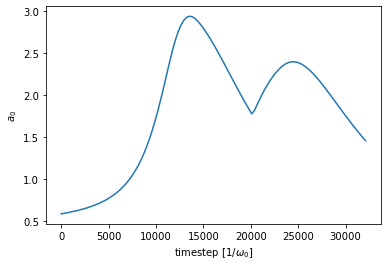

In [10]:
plt.plot(a0_14[0,:],a0_14[1,:])
plt.xlabel('timestep [$1/\omega_0$]')
plt.ylabel('$a_0$')

Text(0, 0.5, '$density [$cm^{-3}$]')

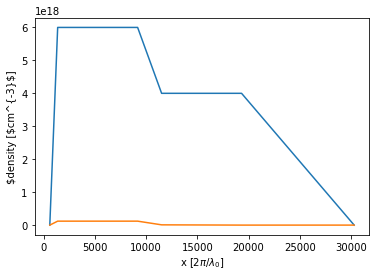

In [11]:
plt.plot(pp_14[0,:],pp_14[1,:]*1e-6) # in cm^-3
plt.plot(pd_14[0,:],pd_14[1,:]*1e-6) # in cm^-3
plt.xlabel('x [$2\pi/\lambda_0$]')
plt.ylabel('$density [$cm^{-3}$]')

### Unit normalisation in Smilei

For ionization simulation the normalisation are the following :

* space : $x_n =\lambda_0/2\pi$ 
* time : $\omega_0 = 2 \pi c/\lambda_0$
* density : $n_c = \epsilon_0 m_e \omega_0^2/e^2$
* energy : $m_e c^2$

A timestep is dt and is given by in $1/\omega_0$ unit

In [12]:
s14.namelist.dt

0.83

The length of a timestep is given by dx in $\lambda_0/2\pi$ unit 

In [13]:
s14.namelist.dx

1.0

### beam parameters and energy spectrum

we can get the beam parameter for each timestep using the function 

*  __l.beamparam__(S,iteration,species_name="electronfromion",E_min=0,E_max=400,chunk_size=100000000,print_flag=True,save_flag=False)

Return a list which contains :

    [iteration,
    times,
    mean energy,
    $\sigma_E$/E$,Q,
    emittance_y,
    emittance_z,
    rmssize_longitudinal,
    rmssize_y,
    rmssize_z,
    divergence_rms]
    
* Energy : $<E>$ in MeV
* energy spread : $\sigma_E/E$ in MeV
* Q in pC
* transverse emittance (y,z) : $\varepsilon_{i:y,z} =\lambda_0 \sqrt{<p_i>^2 <i>^2 - <i p_i >^2} *10^6/(2\pi) $ , in mm.mrad
* rms divergence is  : $\theta_{rms} = \sqrt{ p_y^2/p_x^2 + p_z^2/px^2}$ in mrad
* rms size are defined by : $s_{i:x,y,z} = \lambda_0*\sqrt{<i>^2}*10^6/\pi$ in um.

In [14]:
bp14 = l.beamParam(s14,24000)

/users/flc/cassou/Smilei/happi/_Diagnostics/TrackParticles.py:341: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = self._h5py.File(orderedfile)
/users/flc/cassou/Smilei/happi/_Diagnostics/TrackParticles.py:45: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = self._h5py.File(orderedfile)
/users/flc/cassou/Smilei/happi/_Diagnostics/TrackParticles.py:82: H5pyDeprecationWarning: The d

Selecting particles ... (this may take a while)
Removing dead particles ...
Kept 1280948 particles
dict_keys(['Id', 'x', 'y', 'z', 'px', 'py', 'pz', 'w', 'moving_x'])
Read  672401  particles from the file
Total charge before filter in energy=  32.291782590421676  pC
Total charge after filter in Energy =  32.291782590421676  pC
Filter energy limits:  0 ,  400  (m_e c^2)

--------------------------------------------

Read  672401  particles
Iteration =  24000
Simulation time =  8460.163374465024  fs
E_mean =  84.30238176639511  MeV
2*DeltaE_rms / E_mean =  78.52068394899169  %.
Total charge =  32.291782590421676  pC.
Emittance_y =  16.81329829430733  mm-mrad
Emittance_z =  4.124980433888  mm-mrad
divergence_rms =  0.01938408872684027

--------------------------------------------



to get the spectrum for a given iteration use 

* l.getSpectrum(S,iteration_to_plot,species_name= "electronfromion",horiz_axis_name= "E",chunk_size=100000000,E_min=0,E_max=400,plot_flag=False,print_flag=False)

Selecting particles ... (this may take a while)
Removing dead particles ...
Kept 1280948 particles
dict_keys(['Id', 'x', 'y', 'z', 'px', 'py', 'pz', 'w', 'moving_x'])
Read  672401  particles from the file
Total charge before filter in energy=  32.291782590421676  pC
Total charge after filter in Energy =  32.291782590421676  pC
Filter energy limits:  0 ,  400  (m_e c^2)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Total charge in in the histogram = 32.29178259042173  pC
Bins size: dx =  1.024
200
Values extension for  E  (all particles):
[  2.15583696 202.0222156 ]
Values extension for  E  (particles included in the chosen horiz axis limits):
[  0.  204.8]


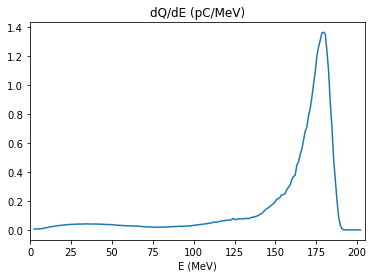

In [15]:
spec = l.getSpectrum(s14,24000,species_name= "electronfromion",horiz_axis_name= "E",chunk_size=100000000,E_min=0,E_max=400,plot_flag=True,print_flag=True)

To get all the particle at the exit of the plasma for beam dynamic transport calculation use 

* __l.getParticles__(s,iteration,species_name="electronfromion",chunk_size=100000000,print_flag = True)

In [16]:
timeSteps = l.getPartAvailableSteps(s14)
last_timeStep = timeSteps[-1]
print('last timesteps=',last_timeStep)

Selecting particles ... (this may take a while)
Removing dead particles ...
Kept 1280948 particles
last timesteps= 32100


/users/flc/cassou/Smilei/happi/_Diagnostics/TrackParticles.py:341: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = self._h5py.File(orderedfile)
/users/flc/cassou/Smilei/happi/_Diagnostics/TrackParticles.py:45: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = self._h5py.File(orderedfile)
/users/flc/cassou/Smilei/happi/_Diagnostics/TrackParticles.py:82: H5pyDeprecationWarning: The d

In [17]:
beampart = l.getParticles(s14,last_timeStep)

Selecting particles ... (this may take a while)
Removing dead particles ...
Kept 1280948 particles


/users/flc/cassou/Smilei/happi/_Diagnostics/TrackParticles.py:663: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = self._h5py.File(file)


dict_keys(['Id', 'x', 'y', 'z', 'px', 'py', 'pz', 'w', 'moving_x'])
Read  646009  particles from the file
Total charge before filter in energy=  31.97751108811239  pC


In [24]:
beampart[0,:].shape

(645898,)

In [56]:
from scipy.stats import kde
x = beampart[0,:],
px = beampart[3,:],
data = np.array([x[0],px[0]])
k = kde.gaussian_kde(data)
nbins = 50
xi, yi = np.mgrid[x[0].min():x[0].max():nbins*1j, px[0].min():px[0].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0.5, 0, 'x [$/\\lambda_0/2\\pi$]')

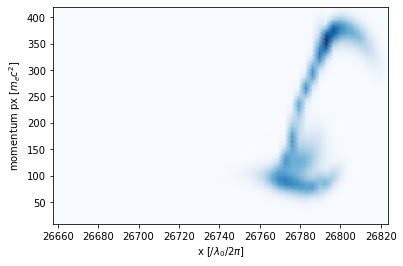

In [58]:
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud',cmap='Blues')
plt.ylabel('momentum px [$m_e c^2$]')
plt.xlabel('x [$/\lambda_0/2\pi$]')